In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from collections import defaultdict

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.meta import BaseSRegressor, BaseXRegressor, BaseTRegressor, BaseDRRegressor
from causalml.inference.tree import CausalRandomForestRegressor
from causalml.inference.tree import CausalTreeRegressor
from causalml.inference.tree.plot import plot_causal_tree
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib64/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib64/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

In [3]:
df = pd.read_csv("bpi2017_final.csv")
print(df.columns)
df.head()

In [4]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='offerSuccess',
               index='treatmentOffer',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,successful,successful
treatment,,
0,0.628749,800338
1,0.693390,397981
All,0.650218,1198319


In [5]:
#new empty column treatment_effect
df['treatment_effect'] = 0

In [7]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11101)
n_test = df_test.shape[0]
n_train = df_train.shape[0]

In [8]:
feature_names = ['NumberOfOffers', 'Action', 'org:resource',
       'concept:name', 'EventOrigin', 'lifecycle:transition', 'time:timestamp',
       'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'CreditScore', 'OfferedAmount', 'offerNumber','timeApplication', 'weekdayApplication']

In [9]:
# Table to gather estimated ITEs by models
df_cforest = pd.DataFrame({
    'outcome': df_test['offerSuccess'],
    'is_treated': df_test['treatmentOffer'],
    'treatment_effect': df_test['treatment_effect']
})

CausalRandomForestRegressor

In [11]:
cforests = {
    'cforest_mse': {
        'params':
        dict(criterion='standard_mse',
             control_name=0,
             min_impurity_decrease=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
    'cforest_cmse': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.,
            groups_cnt=True
        ),
    },
    'cforest_cmse_p=0.5': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'cforest_cmse_p=0.5_md=3': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            max_depth=3,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'cforest_ttest': {
        'params':
        dict(criterion='t_test',
             control_name=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
}

In [12]:
# Model treatment effect
for cforest_name, cforest_info in cforests.items():
    print(f"Fitting: {cforest_name}")
    cforest = CausalRandomForestRegressor(**cforest_info['params'])
    cforest.fit(X=df_train[feature_names].values,
              treatment=df_train['treatmentOffer'].values,
              y=df_train['offerSuccess'].values)

    cforests[cforest_name].update({'model': cforest})
    df_cforest[cforest_name] = cforest.predict(df_test[feature_names].values)

Fitting: cforest_mse
Fitting: cforest_cmse
Fitting: cforest_cmse_p=0.5
Fitting: cforest_cmse_p=0.5_md=3
Fitting: cforest_ttest


In [17]:
cforests

{'cforest_mse': {'params': {'criterion': 'standard_mse',
   'control_name': 0,
   'min_impurity_decrease': 0,
   'min_samples_leaf': 400,
   'groups_penalty': 0.0,
   'groups_cnt': True},
  'model': CausalRandomForestRegressor(criterion='standard_mse', groups_penalty=0.0,
                              min_impurity_decrease=0, min_samples_leaf=400)},
 'cforest_cmse': {'params': {'criterion': 'causal_mse',
   'control_name': 0,
   'min_samples_leaf': 400,
   'groups_penalty': 0.0,
   'groups_cnt': True},
  'model': CausalRandomForestRegressor(groups_penalty=0.0, min_samples_leaf=400)},
 'cforest_cmse_p=0.5': {'params': {'criterion': 'causal_mse',
   'control_name': 0,
   'min_samples_leaf': 400,
   'groups_penalty': 0.5,
   'groups_cnt': True},
  'model': CausalRandomForestRegressor(min_samples_leaf=400)},
 'cforest_cmse_p=0.5_md=3': {'params': {'criterion': 'causal_mse',
   'control_name': 0,
   'max_depth': 3,
   'min_samples_leaf': 400,
   'groups_penalty': 0.5,
   'groups_cnt': True}

In [16]:
df_cforest

,outcome,is_treated,treatment_effect,cforest_mse,cforest_cmse,cforest_cmse_p=0.5,cforest_cmse_p=0.5_md=3,cforest_ttest
862609,1,0,0,-0.000183,0.000000,0.000000,0.298548,0.000000
1158138,0,1,0,0.292355,0.246118,0.253140,0.269037,0.231186
603398,0,1,0,0.370187,0.602621,0.644631,0.238563,0.598429
780790,1,1,0,0.326218,0.458975,0.212267,0.154351,0.543732
531743,1,0,0,-0.000183,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
921849,0,0,0,0.349125,0.448008,0.387352,0.238563,0.589774
189652,1,0,0,-0.000183,0.000000,0.000000,0.000000,0.000000
914548,0,0,0,0.326218,0.318646,0.307713,0.154351,0.352455
238437,1,0,0,-0.000183,0.000000,0.000000,0.000000,0.000000


### Result in result df
Das sind die ITE, also der Durchschnitt ist dann ATE

In [ ]:
%store -r df_results
lib = "CausalML"

for i in range(3, len(df_cforest.columns)):
    method = df_cforest.columns[i]
    ite = df_cforest[i]
    ate = ite.mean()

    if method in df_results['method'].values:
         # If the method is already in the DataFrame, update the ATE and ITE columns
        df_results.loc[df_results['method'] == method, 'ATE'] = ate
        df_results.loc[df_results['method'] == method, 'ITE'] = [ite]
    else:
        # If the method is not in the DataFrame, add a new row
        df_results = df_results._append({'method': method, 'ATE': ate, 'ITE': ite, 'Library': lib}, ignore_index=True)

print(df_results)
%store df_results

### Other shit

In [18]:
df_qini = qini_score(df_result,
           outcome_col='outcome',
           treatment_col='is_treated')

df_qini.sort_values(ascending=False)

cforest_ttest              1.917502
cforest_cmse               1.860046
cforest_cmse_p=0.5         1.795352
cforest_mse                1.354842
cforest_cmse_p=0.5_md=3    1.155710
Random                     0.000000
treatment_effect          -0.003818
dtype: float64

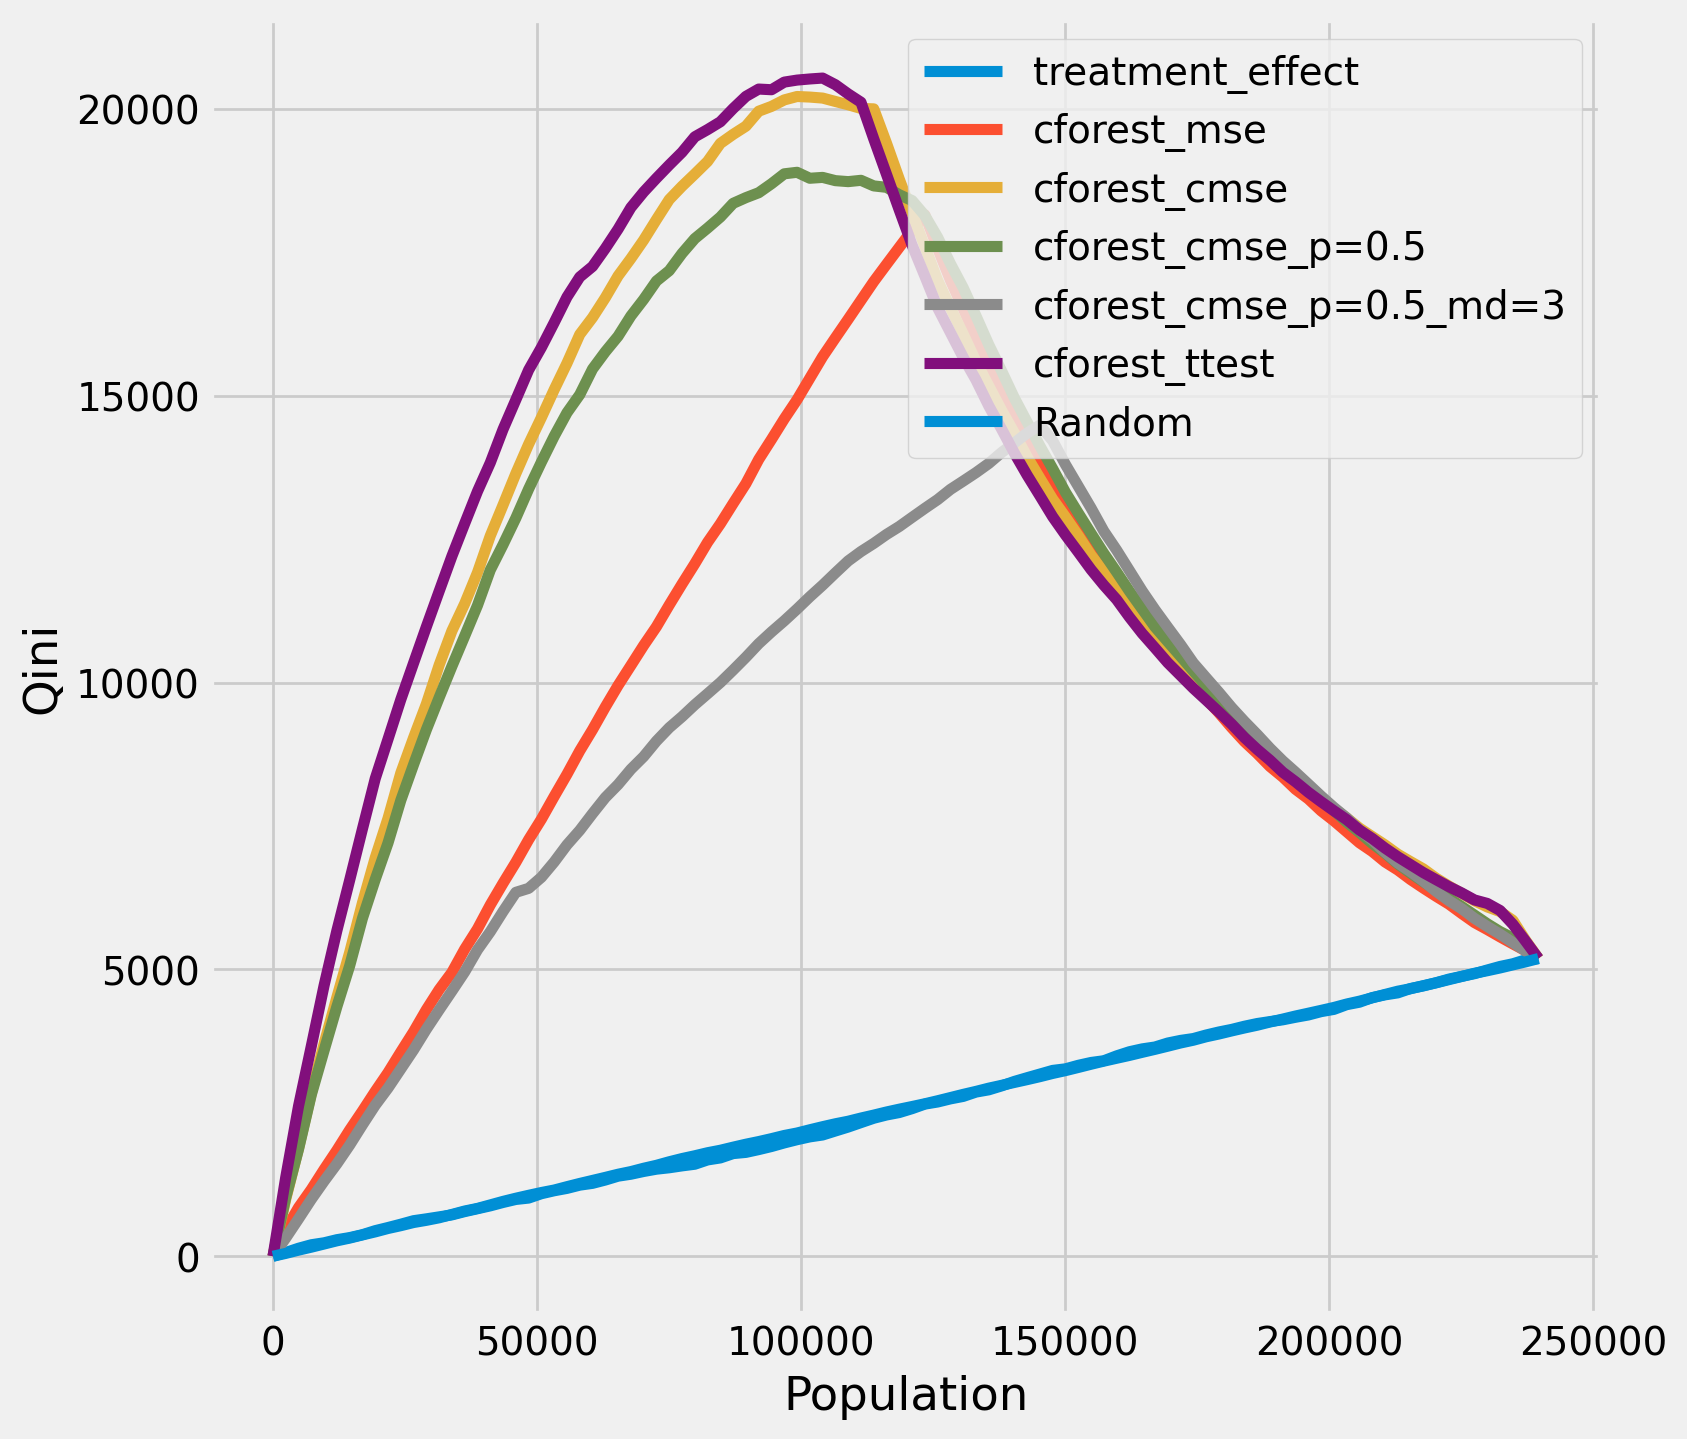

In [19]:
plot_qini(df_result,
          outcome_col='outcome',
          treatment_col='is_treated',
          figsize=(8,8)
         )

In [29]:
ctree = CausalTreeRegressor()
ctree.fit(X=df_train[feature_names].values, y=df_train['successful'].values, treatment=df_train['treatment'].values)

CausalTreeRegressor()

In [28]:
crforest = CausalRandomForestRegressor(criterion="causal_mse",
                                  min_samples_leaf=200,
                                  control_name=0,
                                  n_estimators=50,
                                  n_jobs=mp.cpu_count() - 1)
crforest.fit(X=df_test[feature_names].values, y=df_test['successful'].values, treatment=df_test['treatment'].values)

CausalRandomForestRegressor(min_samples_leaf=200, n_estimators=50, n_jobs=79)

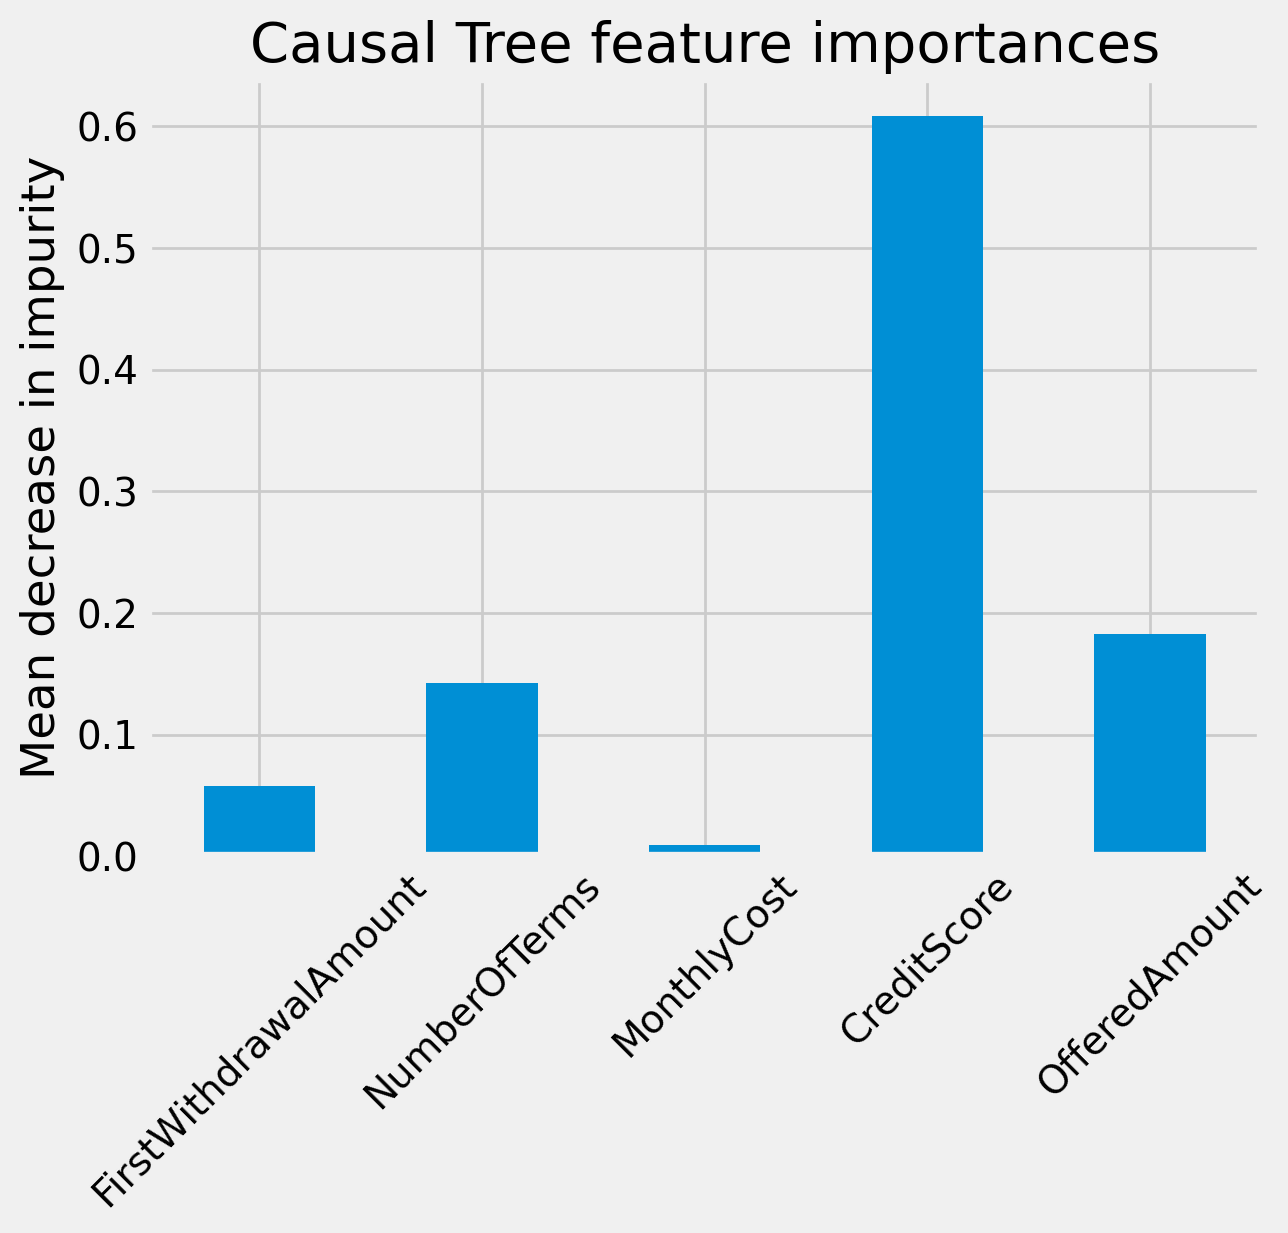

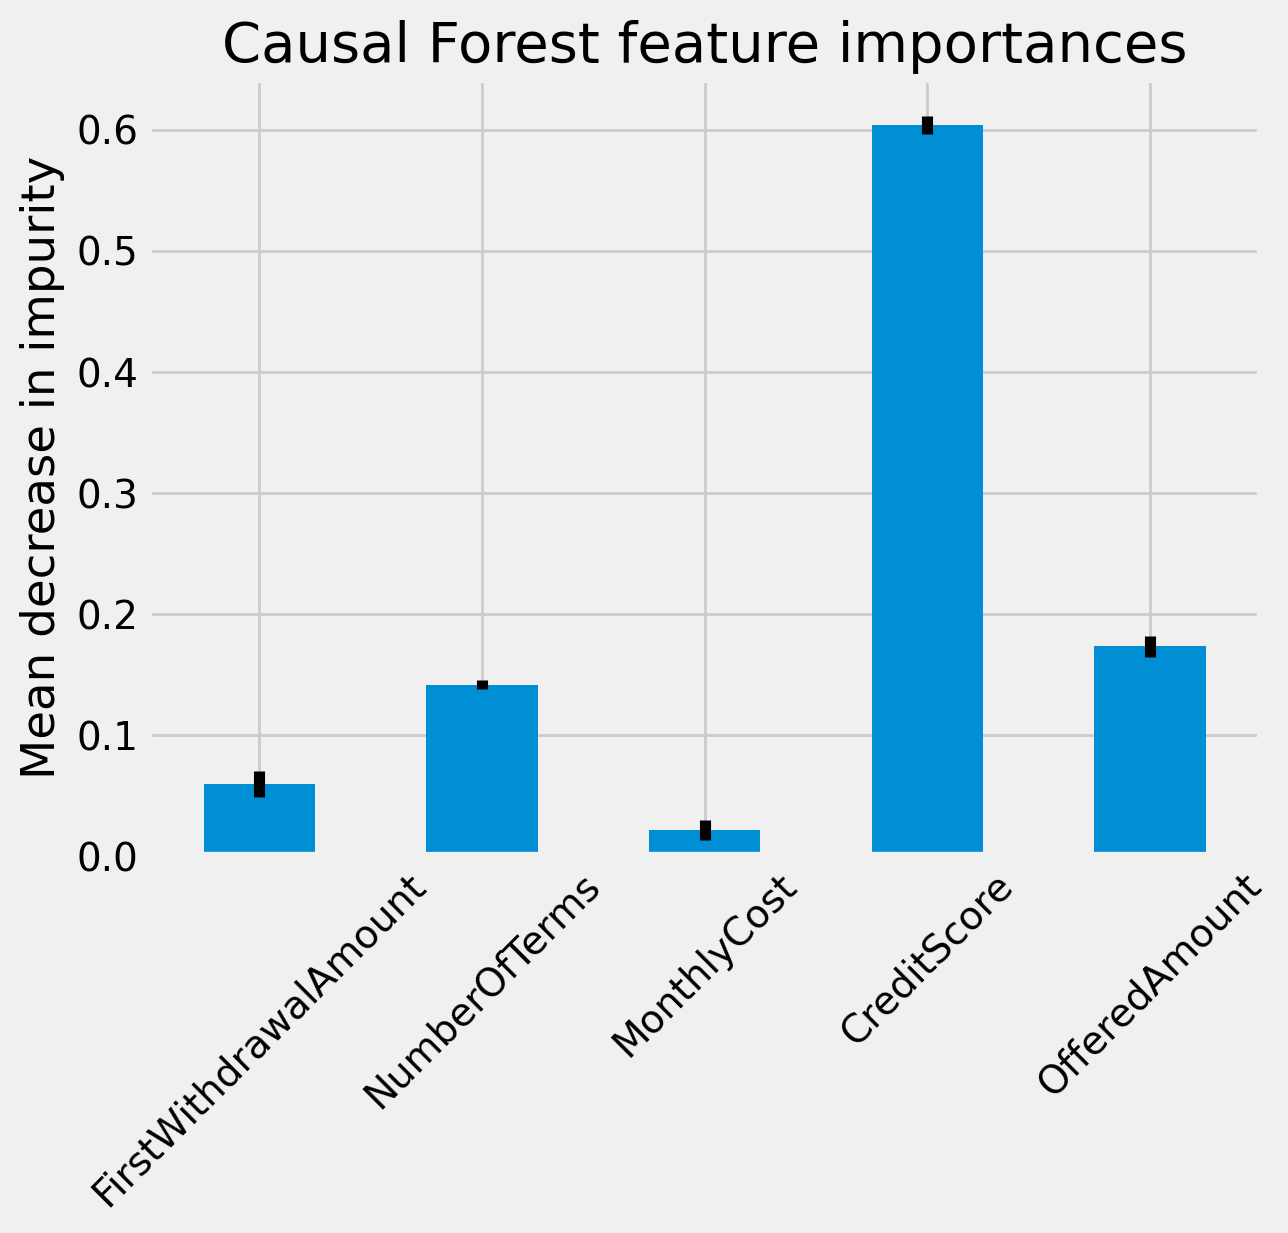

In [30]:
df_importances = pd.DataFrame({'tree': ctree.feature_importances_,
                               'forest': crforest.feature_importances_,
                               'feature': feature_names
                              })
forest_std = np.std([tree.feature_importances_ for tree in crforest.estimators_], axis=0)

fig, ax = plt.subplots()
df_importances['tree'].plot.bar(ax=ax)
ax.set_title("Causal Tree feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

fig, ax = plt.subplots()
df_importances['forest'].plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Causal Forest feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

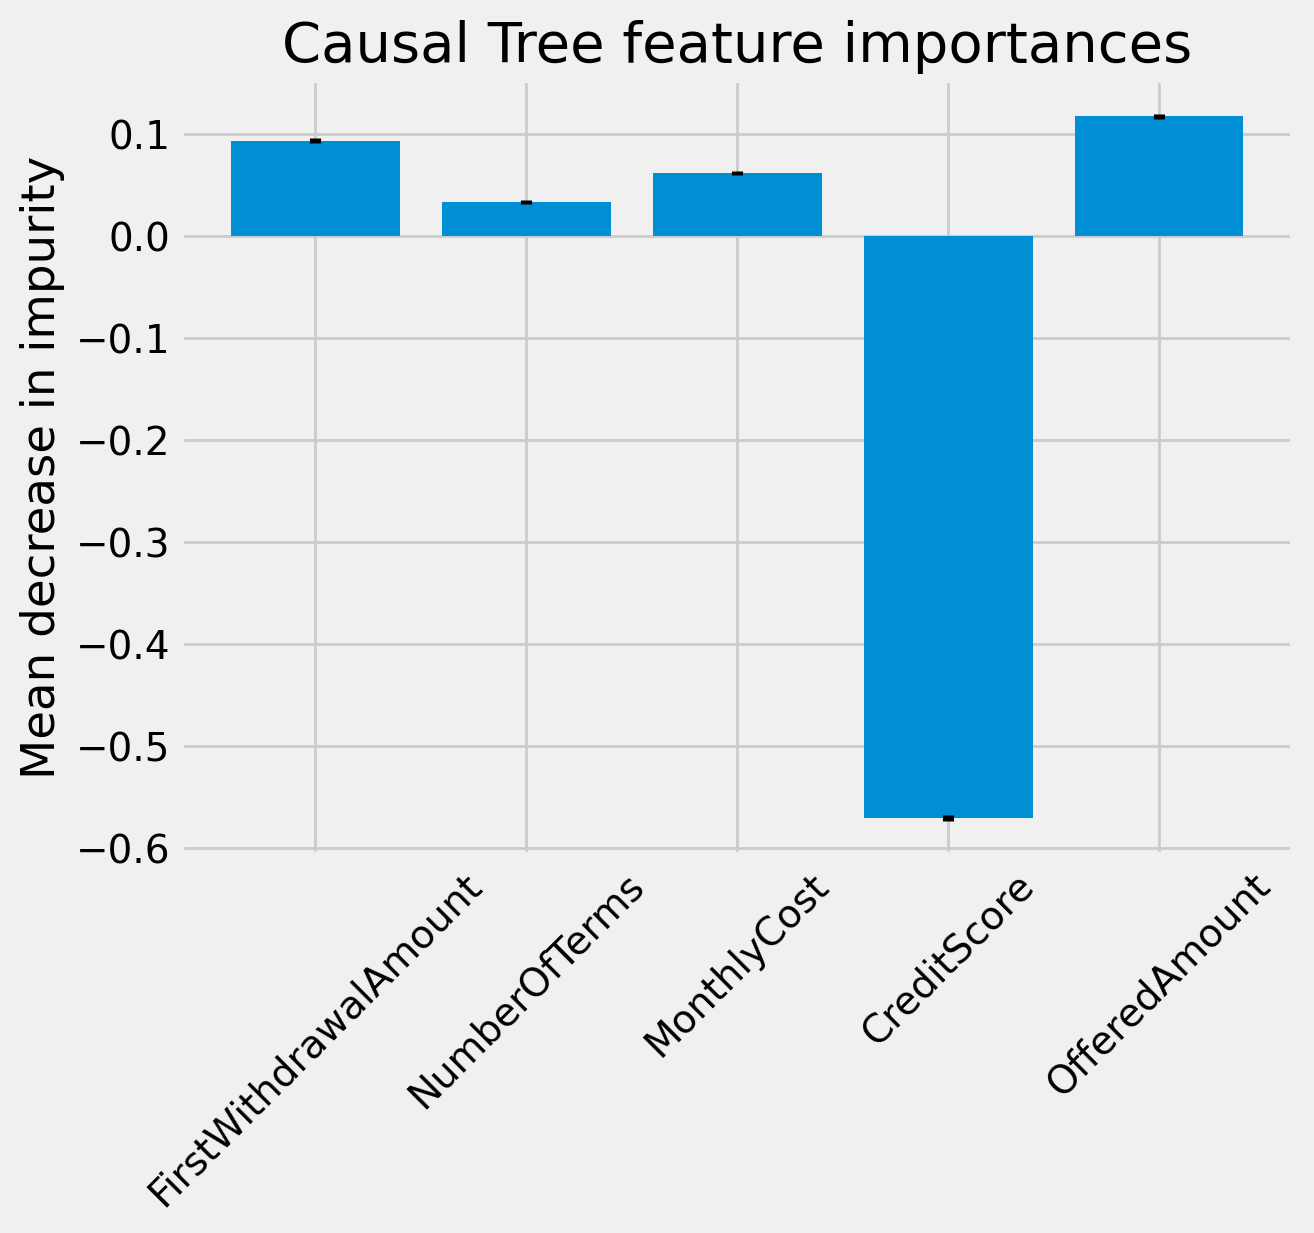

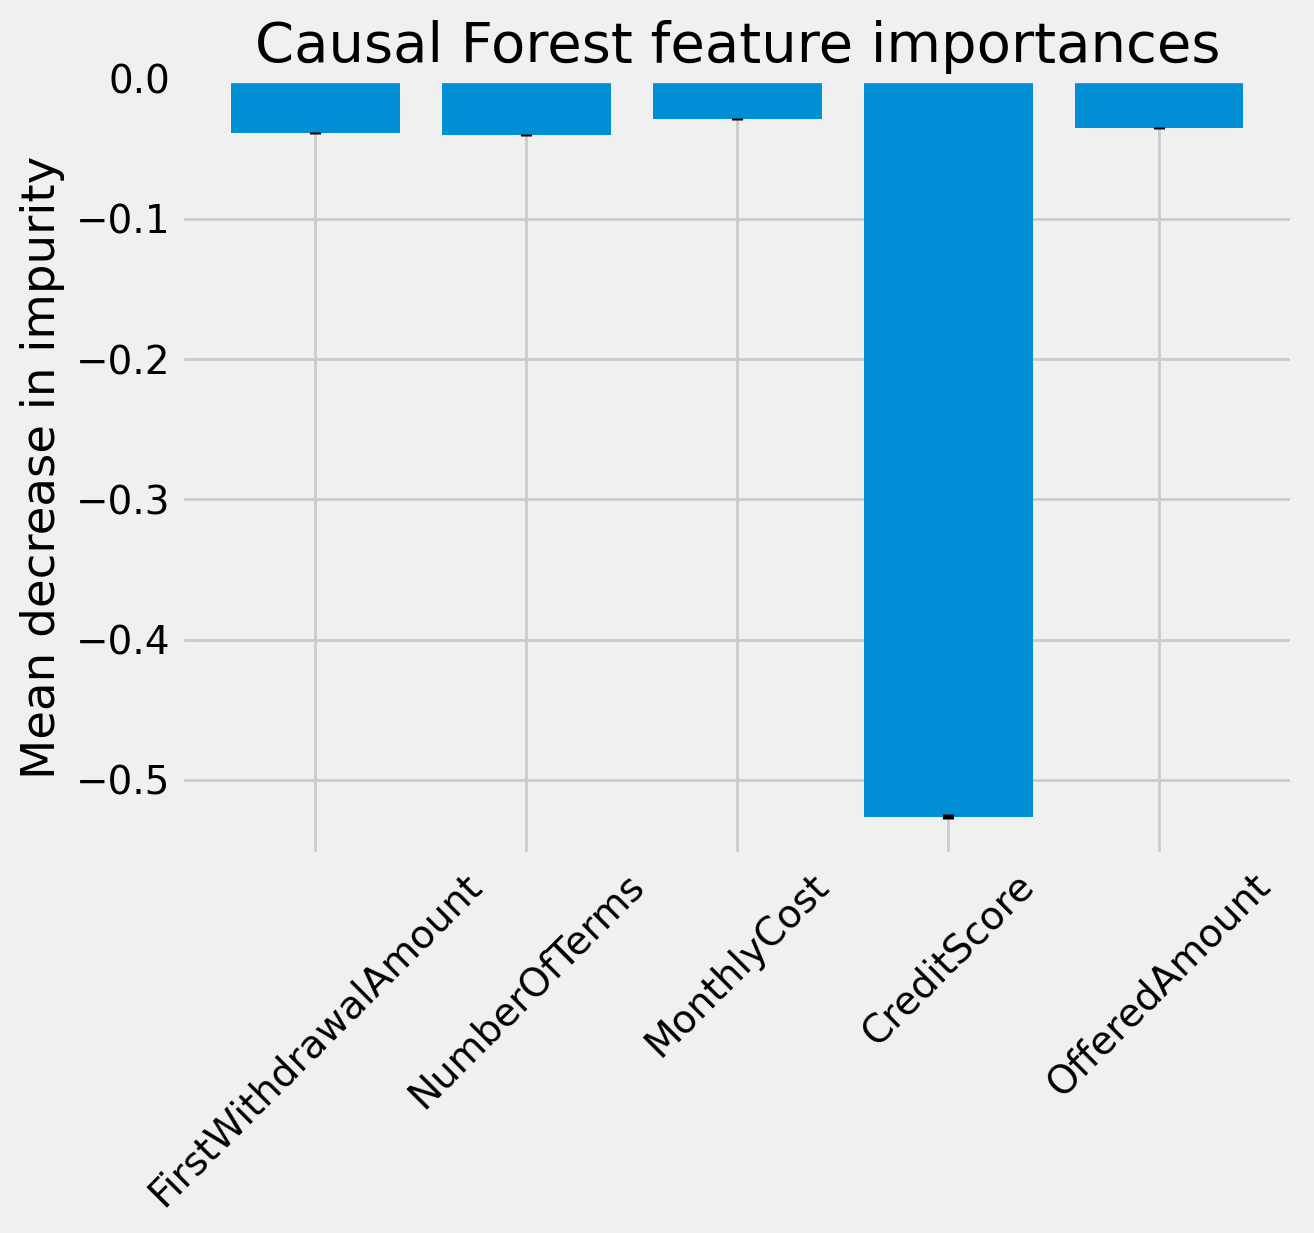

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
for name, model in zip(('Causal Tree', 'Causal Forest'), (ctree, crforest)):

    imp = permutation_importance(model, df_test[feature_names], df_test['successful'].values,
                                 n_repeats=50,
                                 random_state=0)

    fig, ax = plt.subplots()
    ax.set_title(f"{name} feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    plt.bar(feature_names, imp['importances_mean'], yerr=imp['importances_std'])
    ax.set_xticklabels(feature_names, rotation=45)
    plt.show()

In [35]:
# Tree Explainer for treatment=0
cforest_explainer = shap.TreeExplainer(crforest)
shap.initjs()
shap_values = cforest_explainer.shap_values(observation)
shap.force_plot(cforest_explainer.expected_value[0],
                shap_values[0],
                observation)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'causalml.inference.tree.causal.causalforest.CausalRandomForestRegressor'>

In [8]:
ctrees = {
    'ctree_mse': {
        'params':
        dict(criterion='standard_mse',
             control_name=0,
             min_impurity_decrease=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
    'ctree_cmse': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.1': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.1,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.25': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.25,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.5': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'ctree_ttest': {
        'params':
        dict(criterion='t_test',
             control_name=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
}

In [24]:
# Model treatment effect
for ctree_name, ctree_info in ctrees.items():
    print(f"Fitting: {ctree_name}")
    ctree = CausalTreeRegressor(**ctree_info['params'])
    ctree.fit(X=df_train[feature_names].values,
              treatment=df_train['treatment'].values,
              y=df_train['successful'].values)

    ctrees[ctree_name].update({'model': ctree})
    df_result[ctree_name] = ctree.predict(df_test[feature_names].values)

Fitting: ctree_mse
Fitting: ctree_cmse
Fitting: ctree_cmse_p=0.1
Fitting: ctree_cmse_p=0.25
Fitting: ctree_cmse_p=0.5
Fitting: ctree_ttest


In [ ]:
df_result

In [24]:
df_qiniCtree = qini_score(df_result,
           outcome_col='outcome',
           treatment_col='is_treated')

df_qiniCtree.sort_values(ascending=False)
plot_qini(df_result,
          outcome_col='successful',
          treatment_col='is_treated',
          figsize=(5,5)
         )

AssertionError: 

In [ ]:
cforests = {
    'cforest_mse': {
        'params':
        dict(criterion='standard_mse',
             control_name=0,
             min_impurity_decrease=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
    'cforest_cmse': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.,
            groups_cnt=True
        ),
    },
    'cforest_cmse_p=0.5': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'cforest_cmse_p=0.5_md=3': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            max_depth=3,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'cforest_ttest': {
        'params':
        dict(criterion='t_test',
             control_name=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
}